In [6]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import dask.dataframe as dk
import calendar
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,Normalizer
from xgboost import XGBRegressor
from scipy.sparse import csr_matrix,hstack
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from sklearn.linear_model import SGDRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import AdaBoostRegressor
import pickle

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
train=pd.read_csv('/content/drive/MyDrive/train1.csv')

In [9]:
cv=pd.read_csv('cross_validation_df.csv')
test=pd.read_csv('test_df.csv')
final_test=pd.read_csv('final_test_df.csv')

In [1]:
dtype = {
    # Object (string) types
    'id': 'object',
    'd': 'object',
    'date': 'object',
    'holiday': 'object',
    'season': 'object',

    # Integer types
    'item_id': 'int64',
    'dept_id': 'int8',
    'cat_id': 'int8',
    'store_id': 'int8',
    'state_id': 'int8',
    'wday': 'int8',
    'month': 'int8',
    'year': 'int16',
    'event_name_1': 'int8',
    'event_type_1': 'int8',
    'event_name_2': 'int8',
    'event_type_2': 'int8',
    'snap': 'int8',
    'week_number': 'int8',
    'quater_start': 'int8',
    'quater_end': 'int8',
    'month_start': 'int8',
    'month_end': 'int8',
    'year_start': 'int8',
    'year_end': 'int8',
    'direct_lag_28': 'int16',
    'direct_lag_35': 'int16',
    'direct_lag_42': 'int16',
    'direct_lag_49': 'int16',
    'direct_lag_56': 'int16',
    'direct_lag_63': 'int16',
    'direct_lag_70': 'int16',
    'direct_lag_77': 'int16',
    'direct_lag_84': 'int16',
    'direct_lag_91': 'int16',
    'direct_lag_98': 'int16',

    # Float types
    'sell_price': 'float16',
    'roll_7_shift_28_mean': 'float16',
    'roll_14_shift_28_mean': 'float16',
    'roll_30_shift_28_mean': 'float16',
    'roll_60_shift_28_mean': 'float16',
    'roll_360_shift_28_mean': 'float16',
    'roll_7_shift_28_std': 'float16',
    'roll_14_shift_28_std': 'float16',
    'roll_30_shift_28_std': 'float16',
    'roll_60_shift_28_std': 'float16',
    'roll_360_shift_28_std': 'float16',
    'direct_ewm': 'float16',
}


def update_dtypes(df, dtype_dict):
    # Iterate through the dictionary
    for column, dtype in dtype_dict.items():
        # Check if the column exists in the DataFrame
        if column in df.columns:
            try:
                # Fill NaN values with zero before conversion
                # This is particularly important for numeric conversions
                if pd.api.types.is_numeric_dtype(dtype) or dtype in ['float16', 'float32', 'float64', 'int8', 'int16', 'int32', 'int64']:
                    df[column] = df[column].fillna(0)

                # Change the column data type
                df[column] = df[column].astype(dtype)
            except Exception as e:
                # Handle errors if conversion fails, e.g., due to incompatible data
                print(f"Could not convert column {column} to {dtype}: {e}")
    return df

In [11]:
final_test = update_dtypes(final_test, dtype)
cv = update_dtypes(cv, dtype)
test = update_dtypes(test, dtype)
train = update_dtypes(train, dtype)

## Calculating WRMSSE

In [13]:
def caluclate_WRMSSE(actual,predicted,train,weights,h,n):
    '''This function is used to calculate RMSSE'''
    num=((actual-predicted)**2).sum(axis=1)/h
    denom=(train[:,1:]-train[:,:-1])**2
    denom=denom.sum(axis=1)/(n-1)
    return (num/denom)**0.5

In [14]:
def get_model_performances(model,train,cv,test,X_cv,X_test):
    '''This Function is used to get WRMSSE that is used in this Case Study as a Metric For CV and Test Data'''
    #For CV Data
    cv['prices']=cv['sales']*cv['sell_price']
    total_sales=cv.groupby('id').sum()
    total=sum(total_sales['sales'])
    weight={}
    for i in total_sales.index:
        weight[i]=total_sales.loc[i]['sales']/total
    train1=pd.concat([train,cv])
    train1.sort_values(['id','date'],inplace=True)
    train1.fillna(0,inplace=True)
    df=train1.pivot_table(index=['id','state_id','store_id','cat_id','dept_id','item_id'],columns='d',values='sales')
    df.reset_index(level=[0,1,2,3,4,5],inplace=True)
    df.fillna(0,inplace=True)
    del train1
    import gc
    cv['pred_sales']=model.predict(X_cv)
    df1=cv.pivot_table(index=['id'],columns='d',values='pred_sales')
    dic={}
    for j,i in enumerate(range(1886,1914)):
        dic['d_'+str(i)]='F'+str(j+1)
    df1=df1.rename(columns=dic)
    df1.reset_index(level=[0],inplace=True)
    dd=df.merge(df1,on='id')
    dd['weight']=dd['id'].apply(lambda x:weight[x])
    l=['d_'+str(i) for i in range(1,1914)]
    l1=['F'+str(i) for i in range(1,29)]
    agg_level={2:['state_id'],3:['store_id'],4:['cat_id'],5:['dept_id'],6:['state_id','cat_id'],\
           7:['state_id','dept_id'],8:['store_id','cat_id'],9:['store_id','dept_id'],10:['item_id'],11:['item_id','state_id']}
    agg=pd.DataFrame(dd[l+l1].sum()).transpose()
    agg['weight']=1/12
    agg['level']=1
    col=agg.columns
    for level in agg_level:
        temp_df=dd.groupby(by=agg_level[level]).sum().reset_index(drop=True)
        temp_df['weight']/=12
        temp_df['level']=level
        agg=agg.append(temp_df[col])
    dd['weight']/=12
    dd['level']=12
    agg=agg.append(dd[col])
    actual=agg[['d_1886', 'd_1887', 'd_1888', 'd_1889', 'd_1890', 'd_1891', 'd_1892',
       'd_1893', 'd_1894', 'd_1895', 'd_1896', 'd_1897', 'd_1898', 'd_1899',
       'd_1900', 'd_1901', 'd_1902', 'd_1903', 'd_1904', 'd_1905', 'd_1906',
       'd_1907', 'd_1908', 'd_1909', 'd_1910', 'd_1911', 'd_1912', 'd_1913']].values
    predicted=agg[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21',
       'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28']].values
    training=agg[['d_'+str(i) for i in range(1,1886)]].values
    weights=agg['weight'].values
    rmsse=caluclate_WRMSSE(actual,predicted,training,weights,28,1886)
    cv_wrsmme=np.sum(rmsse*weights)
    cv.drop(['pred_sales'],axis=1,inplace=True)
    del actual,predicted,training,weights,agg

    #For Test data
    test['prices']=test['sales']*test['sell_price']
    total_sales=test.groupby('id').sum()
    total=sum(total_sales['sales'])
    weight={}
    for i in total_sales.index:
        weight[i.replace('evaluation','validation')]=total_sales.loc[i]['sales']/total
    test['id']=test['id'].apply(lambda x:x.replace('evaluation','validation'))
    train1=pd.concat([train,cv,test])
    train1.sort_values(['id','date'],inplace=True)
    train1.fillna(0,inplace=True)
    df=train1.pivot_table(index=['id','state_id','store_id','cat_id','dept_id','item_id'],columns='d',values='sales')
    df.reset_index(level=[0,1,2,3,4,5],inplace=True)
    df.fillna(0,inplace=True)
    del train1
    import gc
    test['pred_sales']=model.predict(X_test)
    df1=test.pivot_table(index=['id'],columns='d',values='pred_sales')
    dic={}
    for j,i in enumerate(range(1914,1942)):
        dic['d_'+str(i)]='F'+str(j+1)
    df1=df1.rename(columns=dic)
    df1.reset_index(level=[0],inplace=True)
    dd=df.merge(df1,on='id')
    dd['weight']=dd['id'].apply(lambda x:weight[x])
    l=['d_'+str(i) for i in range(1,1942)]
    l1=['F'+str(i) for i in range(1,29)]
    agg_level={2:['state_id'],3:['store_id'],4:['cat_id'],5:['dept_id'],6:['state_id','cat_id'],\
           7:['state_id','dept_id'],8:['store_id','cat_id'],9:['store_id','dept_id'],10:['item_id'],11:['item_id','state_id']}
    agg=pd.DataFrame(dd[l+l1].sum()).transpose()
    agg['weight']=1/12
    agg['level']=1
    col=agg.columns
    for level in agg_level:
        temp_df=dd.groupby(by=agg_level[level]).sum().reset_index(drop=True)
        temp_df['weight']/=12
        temp_df['level']=level
        agg=agg.append(temp_df[col])
    dd['weight']/=12
    dd['level']=12
    agg=agg.append(dd[col])
    actual=agg[['d_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919',
       'd_1920', 'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925',
       'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 'd_1931',
       'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937',
       'd_1938', 'd_1939', 'd_1940', 'd_1941']].values
    predicted=agg[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21',
       'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28']].values
    training=agg[['d_'+str(i) for i in range(1,1914)]].values
    weights=agg['weight'].values
    rmsse=caluclate_WRMSSE(actual,predicted,training,weights,28,1914)
    test_wrsmme=np.sum(rmsse*weights)

    print("CV WRMSSE=",cv_wrsmme)
    print("Test WRMSSE=",test_wrsmme)

In [15]:
def get_model_performances_for_store_wise_trained_model(train,cv,test,cv_pred,test_pred):
    '''This Function is used to get WRMSSE that is used in this Case Study as a Metric For CV and Test Data where model is trained according to store id(Mainly used for Catabosst)'''
    #For CV Data
    cv['prices']=cv['sales']*cv['sell_price']
    total_sales=cv.groupby('id').sum()
    total=sum(total_sales['sales'])
    weight={}
    for i in total_sales.index:
        weight[i]=total_sales.loc[i]['sales']/total
    train1=pd.concat([train,cv])
    train1.sort_values(['id','date'],inplace=True)
    train1.fillna(0,inplace=True)
    df=train1.pivot_table(index=['id','state_id','store_id','cat_id','dept_id','item_id'],columns='d',values='sales')
    df.reset_index(level=[0,1,2,3,4,5],inplace=True)
    df.fillna(0,inplace=True)
    del train1
    import gc

    df1=cv_pred
    dd=df.merge(df1,on='id')
    dd['weight']=dd['id'].apply(lambda x:weight[x])
    l=['d_'+str(i) for i in range(1,1914)]
    l1=['F'+str(i) for i in range(1,29)]
    agg_level={2:['state_id'],3:['store_id'],4:['cat_id'],5:['dept_id'],6:['state_id','cat_id'],\
           7:['state_id','dept_id'],8:['store_id','cat_id'],9:['store_id','dept_id'],10:['item_id'],11:['item_id','state_id']}
    agg=pd.DataFrame(dd[l+l1].sum()).transpose()
    agg['weight']=1/12
    agg['level']=1
    col=agg.columns
    for level in agg_level:
        temp_df=dd.groupby(by=agg_level[level]).sum().reset_index(drop=True)
        temp_df['weight']/=12
        temp_df['level']=level
        agg=agg.append(temp_df[col])
    dd['weight']/=12
    dd['level']=12
    agg=agg.append(dd[col])
    actual=agg[['d_1886', 'd_1887', 'd_1888', 'd_1889', 'd_1890', 'd_1891', 'd_1892',
       'd_1893', 'd_1894', 'd_1895', 'd_1896', 'd_1897', 'd_1898', 'd_1899',
       'd_1900', 'd_1901', 'd_1902', 'd_1903', 'd_1904', 'd_1905', 'd_1906',
       'd_1907', 'd_1908', 'd_1909', 'd_1910', 'd_1911', 'd_1912', 'd_1913']].values
    predicted=agg[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21',
       'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28']].values
    training=agg[['d_'+str(i) for i in range(1,1886)]].values
    weights=agg['weight'].values
    rmsse=caluclate_WRMSSE(actual,predicted,training,weights,28,1886)
    cv_wrsmme=np.sum(rmsse*weights)
    del actual,predicted,training,weights,agg

    #For Test data
    test['prices']=test['sales']*test['sell_price']
    total_sales=test.groupby('id').sum()
    total=sum(total_sales['sales'])
    weight={}
    for i in total_sales.index:
        weight[i.replace('evaluation','validation')]=total_sales.loc[i]['sales']/total
    test['id']=test['id'].apply(lambda x:x.replace('evaluation','validation'))
    train1=pd.concat([train,cv,test])
    train1.sort_values(['id','date'],inplace=True)
    train1.fillna(0,inplace=True)
    df=train1.pivot_table(index=['id','state_id','store_id','cat_id','dept_id','item_id'],columns='d',values='sales')
    df.reset_index(level=[0,1,2,3,4,5],inplace=True)
    df.fillna(0,inplace=True)
    del train1
    import gc
    df1=test_pred
    df1['id']=df1['id'].apply(lambda x:x.replace('evaluation','validation'))
    dd=df.merge(df1,on='id')
    dd['weight']=dd['id'].apply(lambda x:weight[x])
    l=['d_'+str(i) for i in range(1,1942)]
    l1=['F'+str(i) for i in range(1,29)]
    agg_level={2:['state_id'],3:['store_id'],4:['cat_id'],5:['dept_id'],6:['state_id','cat_id'],\
           7:['state_id','dept_id'],8:['store_id','cat_id'],9:['store_id','dept_id'],10:['item_id'],11:['item_id','state_id']}
    agg=pd.DataFrame(dd[l+l1].sum()).transpose()
    agg['weight']=1/12
    agg['level']=1
    col=agg.columns
    for level in agg_level:
        temp_df=dd.groupby(by=agg_level[level]).sum().reset_index(drop=True)
        temp_df['weight']/=12
        temp_df['level']=level
        agg=agg.append(temp_df[col])
    dd['weight']/=12
    dd['level']=12
    agg=agg.append(dd[col])
    actual=agg[['d_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919',
       'd_1920', 'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925',
       'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 'd_1931',
       'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937',
       'd_1938', 'd_1939', 'd_1940', 'd_1941']].values
    predicted=agg[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21',
       'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28']].values
    training=agg[['d_'+str(i) for i in range(1,1914)]].values
    weights=agg['weight'].values
    rmsse=caluclate_WRMSSE(actual,predicted,training,weights,28,1914)
    test_wrsmme=np.sum(rmsse*weights)

    print("CV WRMSSE=",cv_wrsmme)
    print("Test WRMSSE=",test_wrsmme)


## Model Architecture

In [16]:
tf.keras.backend.clear_session()
input1=tf.keras.layers.Input(shape=1,name='Item_Id')
input2=tf.keras.layers.Input(shape=1,name='Dept_Id')
input3=tf.keras.layers.Input(shape=1,name='Cat_Id')
input4=tf.keras.layers.Input(shape=1,name='Store_Id')
input5=tf.keras.layers.Input(shape=1,name='State_Id')
input6=tf.keras.layers.Input(shape=1,name='year')
input7=tf.keras.layers.Input(shape=1,name='event_name_1')
input8=tf.keras.layers.Input(shape=1,name='event_name_2')
input9=tf.keras.layers.Input(shape=1,name='season')
input10=tf.keras.layers.Input(shape=(1,23),name='Numerical_features')

emb1=tf.keras.layers.Embedding(3050,output_dim=150)(input1)
emb2=tf.keras.layers.Embedding(8,output_dim=10)(input2)
emb3=tf.keras.layers.Embedding(4,output_dim=10)(input3)
emb4=tf.keras.layers.Embedding(11,output_dim=10)(input4)
emb5=tf.keras.layers.Embedding(4,output_dim=10)(input5)
emb6=tf.keras.layers.Embedding(2017,output_dim=10)(input6)
emb7=tf.keras.layers.Embedding(32,output_dim=10)(input7)
emb8=tf.keras.layers.Embedding(6,output_dim=10)(input8)
emb9=tf.keras.layers.Embedding(5,output_dim=10)(input9)

lstm1=tf.keras.layers.LSTM(50)(emb1)
lstm2=tf.keras.layers.LSTM(10)(emb2)
lstm3=tf.keras.layers.LSTM(10)(emb3)
lstm4=tf.keras.layers.LSTM(10)(emb4)
lstm5=tf.keras.layers.LSTM(10)(emb5)
lstm6=tf.keras.layers.LSTM(10)(emb6)
lstm7=tf.keras.layers.LSTM(10)(emb7)
lstm8=tf.keras.layers.LSTM(10)(emb8)
lstm9=tf.keras.layers.LSTM(10)(emb9)
lstm10=tf.keras.layers.LSTM(10)(input10)

x1=tf.keras.layers.Flatten()(lstm1)
x2=tf.keras.layers.Flatten()(lstm2)
x3=tf.keras.layers.Flatten()(lstm3)
x4=tf.keras.layers.Flatten()(lstm4)
x5=tf.keras.layers.Flatten()(lstm5)
x6=tf.keras.layers.Flatten()(lstm6)
x7=tf.keras.layers.Flatten()(lstm7)
x8=tf.keras.layers.Flatten()(lstm8)
x9=tf.keras.layers.Flatten()(lstm9)
x10=tf.keras.layers.Flatten()(input10)

x=tf.keras.layers.Concatenate()([x1,x2,x3,x4,x5,x6,x7,x8,x9,x10])
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(256,activation='sigmoid')(x)
x=tf.keras.layers.Dense(128,activation='tanh')(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
x=tf.keras.layers.Dense(1)(x)
model=tf.keras.Model([input1,input2,input3,input4,input5,input6,input7,input8,input9,input10],x)

In [18]:
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0009),loss='mse')

In [19]:
model.fit(x=[train['item_id'].values.reshape(-1,1),train['dept_id'].values,train['cat_id'].values.reshape(-1,1),train['store_id'].values.reshape(-1,1),\
             train['state_id'].values.reshape(-1,1),train['year'].values.reshape(-1,1),train['event_name_1'].values.reshape(-1,1),train['event_name_2'].values.reshape(-1,1),\
             train['season'].values.reshape(-1,1),train[[ 'roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)],\
          y=train['sales'],epochs=15,verbose=1,batch_size=50000,\
          validation_data=([cv['item_id'].values.reshape(-1,1),cv['dept_id'].values,cv['cat_id'].values.reshape(-1,1),cv['store_id'].values.reshape(-1,1),\
             cv['state_id'].values.reshape(-1,1),cv['year'].values.reshape(-1,1),cv['event_name_1'].values.reshape(-1,1),cv['event_name_2'].values.reshape(-1,1),\
             cv['season'].values.reshape(-1,1),cv[[ 'roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)],cv['sales']),workers=5,use_multiprocessing=True)

Epoch 1/15
904/904 [==============================] - 57s 33ms/step - loss: 8.3577 - val_loss: 4.9870
Epoch 2/15
904/904 [==============================] - 26s 29ms/step - loss: 7.3696 - val_loss: 5.0033
Epoch 3/15
904/904 [==============================] - 26s 29ms/step - loss: 7.1261 - val_loss: 4.9548
Epoch 4/15
904/904 [==============================] - 26s 28ms/step - loss: 6.9758 - val_loss: 4.8132
Epoch 5/15
904/904 [==============================] - 26s 29ms/step - loss: 6.8588 - val_loss: 4.7390
Epoch 6/15
904/904 [==============================] - 26s 29ms/step - loss: 6.7560 - val_loss: 4.7958
Epoch 7/15
904/904 [==============================] - 26s 28ms/step - loss: 6.6756 - val_loss: 4.6966
Epoch 8/15
904/904 [==============================] - 26s 28ms/step - loss: 6.6108 - val_loss: 4.7908
Epoch 9/15
904/904 [==============================] - 26s 29ms/step - loss: 6.5582 - val_loss: 4.7383
Epoch 10/15
904/904 [==============================] - 26s 29ms/step - loss: 6.514

In [20]:
get_model_performances(model,train,cv,test,[cv['item_id'].values.reshape(-1,1),cv['dept_id'].values,cv['cat_id'].values.reshape(-1,1),cv['store_id'].values.reshape(-1,1),\
             cv['state_id'].values.reshape(-1,1),cv['year'].values.reshape(-1,1),cv['event_name_1'].values.reshape(-1,1),cv['event_name_2'].values.reshape(-1,1),\
             cv['season'].values.reshape(-1,1),cv[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)],\
                       [test['item_id'].values.reshape(-1,1),test['dept_id'].values,test['cat_id'].values.reshape(-1,1),test['store_id'].values.reshape(-1,1),\
             test['state_id'].values.reshape(-1,1),test['year'].values.reshape(-1,1),test['event_name_1'].values.reshape(-1,1),test['event_name_2'].values.reshape(-1,1),\
             test['season'].values.reshape(-1,1),test[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)])

26679/26679 [==============================] - 140s 5ms/step
CV WRMSSE= 1.1216589309860918
Test WRMSSE= 1.0472808422500042
CPU times: user 13min 52s, sys: 2min 25s, total: 16min 17s
Wall time: 9min 57s


In [21]:
#Predicting for test data
test['pred_sales']=model.predict([test['item_id'].values.reshape(-1,1),test['dept_id'].values,test['cat_id'].values.reshape(-1,1),test['store_id'].values.reshape(-1,1),\
             test['state_id'].values.reshape(-1,1),test['year'].values.reshape(-1,1),test['event_name_1'].values.reshape(-1,1),test['event_name_2'].values.reshape(-1,1),\
             test['season'].values.reshape(-1,1),test[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)])

26679/26679 [==============================] - 140s 5ms/step


In [22]:
#predicting sales for final_test data
final_test['pred_sales']=model.predict([final_test['item_id'].values.reshape(-1,1),test['dept_id'].values,final_test['cat_id'].values.reshape(-1,1),final_test['store_id'].values.reshape(-1,1),\
             final_test['state_id'].values.reshape(-1,1),final_test['year'].values.reshape(-1,1),final_test['event_name_1'].values.reshape(-1,1),final_test['event_name_2'].values.reshape(-1,1),\
             final_test['season'].values.reshape(-1,1),final_test[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)])

26679/26679 [==============================] - 140s 5ms/step


In [23]:
df=test.pivot_table(index='id',columns='date',values='pred_sales')
df.reset_index(level=0,inplace=True)
df['id']=df['id'].apply(lambda x:x.replace('evaluation','validation'))
dic={}
l=test['date'].unique()
for i,day in enumerate(l):
    dic[day]='F'+str(i+1)
df.rename(columns=dic,inplace=True)

In [24]:
df1=final_test.pivot_table(index='id',columns='d',values='pred_sales')
df1.reset_index(level=0,inplace=True)
dic={}
for i,day in enumerate(range(1942,1970)):
    dic['d_'+str(day)]='F'+str(i+1)
df1.rename(columns=dic,inplace=True)

CPU times: user 461 ms, sys: 0 ns, total: 461 ms
Wall time: 460 ms


In [25]:
df2=pd.concat([df1,df])

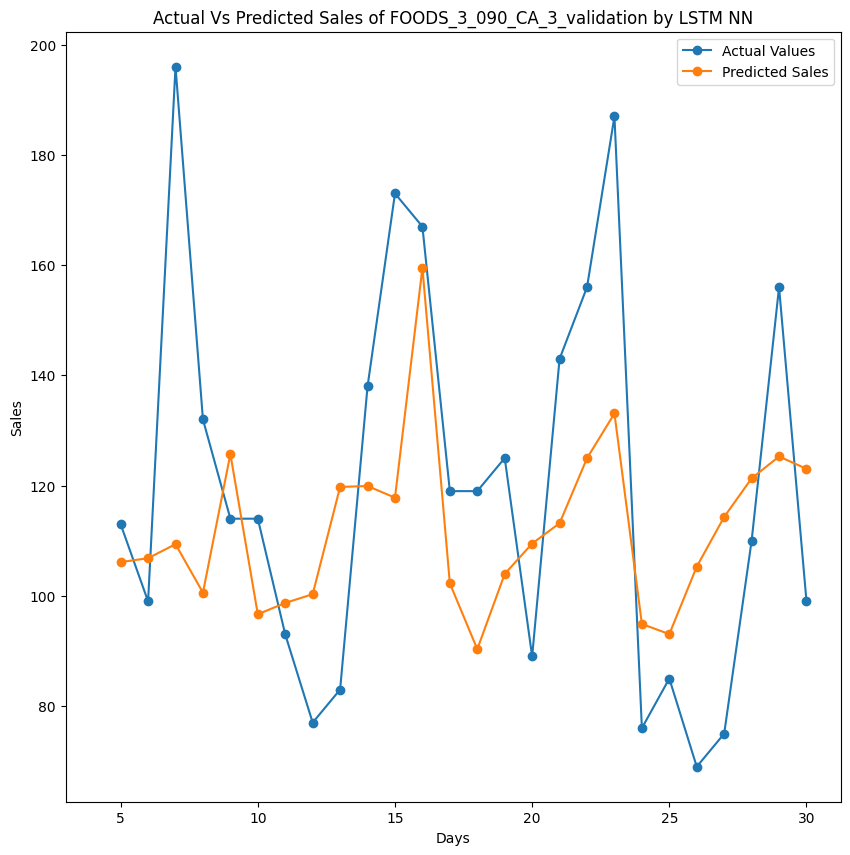

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming nn and test are already defined and preprocessed as per your original code snippet

nn = df2
test.sort_values(['id', 'date'], inplace=True)
tt = test.pivot_table(index='id', values='sales', columns='d')
tt.reset_index(level=0, inplace=True)
tt['id'] = tt['id'].apply(lambda x: x.replace('evaluation', 'validation'))
actual_sales = tt[tt['id'] == 'FOODS_3_090_CA_3_validation'].values.flatten()[1:]
pred_sales = nn[nn['id'] == 'FOODS_3_090_CA_3_validation'].values.flatten()[1:]

plt.figure(figsize=(10, 10))

# Start plotting from the 3rd element (index 2), which corresponds to day 3
days = range(3, len(actual_sales) + 3)

plt.plot(days[2:], actual_sales[2:], label='Actual Values', marker='o')  # Adjusted to start from index 2
plt.plot(days[2:], pred_sales[2:], label='Predicted Sales', marker='o')  # Adjusted to start from index 2

plt.title("Actual Vs Predicted Sales of FOODS_3_090_CA_3_validation by LSTM NN")
plt.ylabel('Sales')
plt.xlabel('Days')

# Set the xlim to start from day 3
plt.xlim(left=3)

plt.legend()
plt.show()